### Import Required Libraries

In [3]:
import os

# Data handling and preprocessing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Model and evaluation
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

# Visualization (optional, but helpful for diagnostics)
import matplotlib.pyplot as plt
import seaborn as sns

# Logging for debugging
import logging

# Set up logging (only once)
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

### Load Data & Select Features (RFE)

In [4]:
import pandas as pd
import os
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# File paths
file_paths = {
    "rfe": "../results/recursive_feature_elimination/recursive_feature_selection_general.csv",  # Updated correct path
    "processed_data": "../processed_data/miRNA_stage_subtype.csv"
}

# Function to load RFE selected features
def load_rfe_features(file_path, num_features=10):
    if os.path.exists(file_path):
        rfe_data = pd.read_csv(file_path)

        # Ensure the required column exists
        if "Feature" in rfe_data.columns:
            selected_features = rfe_data["Feature"].tolist()[:num_features]  # Select top N features
            logging.info(f"Loaded top {num_features} RFE features.")
            return selected_features
        else:
            raise ValueError(f"Expected column 'Feature' not found in {file_path}. Ensure it contains the selected miRNAs.")
    else:
        raise FileNotFoundError(f"RFE feature selection file not found: {file_path}")

# Load processed data
if os.path.exists(file_paths["processed_data"]):
    processed_data = pd.read_csv(file_paths["processed_data"])
else:
    raise FileNotFoundError(f"Processed data file missing: {file_paths['processed_data']}")

# Select top RFE features
num_features_to_select = 500  # Change as needed
top_features = load_rfe_features(file_paths["rfe"], num_features=num_features_to_select)

# Ensure only valid miRNA features are selected (remove metadata like 'stage' and 'subtype' if present)
filtered_features = [feature for feature in top_features if feature.startswith("hsa-mir-")]

# Ensure the selected miRNAs are in the processed dataset
available_features = [feature for feature in filtered_features if feature in processed_data.columns]

# Final Check: Ensure count matches actual miRNAs displayed
logging.info(f"Total valid miRNAs used in classification: {len(available_features)}")

# Display selected miRNAs
print("\nSelected miRNAs for Classification:")
for i, miRNA in enumerate(available_features, 1):
    print(f"{i}. {miRNA}")

# Save cleaned miRNAs to a new CSV file
cleaned_miRNAs_df = pd.DataFrame(available_features, columns=["Selected_miRNAs"])
cleaned_miRNAs_df.to_csv("../results/cleaned_rfe_miRNAs.csv", index=False)

print("\nProcessing complete. Selected features saved.")

2025-02-27 10:04:09,448 - INFO - Loaded top 500 RFE features.
2025-02-27 10:04:09,449 - INFO - Total valid miRNAs used in classification: 50



Selected miRNAs for Classification:
1. hsa-mir-1275
2. hsa-mir-1294
3. hsa-mir-135a-1
4. hsa-mir-181b-1
5. hsa-mir-186
6. hsa-mir-193b
7. hsa-mir-195
8. hsa-mir-19a
9. hsa-mir-218-1
10. hsa-mir-2355
11. hsa-mir-3125
12. hsa-mir-3175
13. hsa-mir-3193
14. hsa-mir-3199-1
15. hsa-mir-3202-1
16. hsa-mir-3654
17. hsa-mir-3655
18. hsa-mir-3688-1
19. hsa-mir-374b
20. hsa-mir-378d-2
21. hsa-mir-3907
22. hsa-mir-425
23. hsa-mir-4284
24. hsa-mir-4434
25. hsa-mir-4435-2
26. hsa-mir-4487
27. hsa-mir-4647
28. hsa-mir-4661
29. hsa-mir-4678
30. hsa-mir-4733
31. hsa-mir-4747
32. hsa-mir-501
33. hsa-mir-5094
34. hsa-mir-5571
35. hsa-mir-5690
36. hsa-mir-571
37. hsa-mir-597
38. hsa-mir-6507
39. hsa-mir-6780b
40. hsa-mir-6808
41. hsa-mir-6811
42. hsa-mir-6868
43. hsa-mir-6872
44. hsa-mir-6888
45. hsa-mir-7111
46. hsa-mir-7151
47. hsa-mir-7843
48. hsa-mir-7849
49. hsa-mir-8085
50. hsa-mir-938

Processing complete. Selected features saved.


### Process Features & Labels for Multi-Output Classification (RFE)

In [5]:
import pandas as pd
import numpy as np
import logging
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Remove rare cases from dataset before train-test split
rare_cases = [(3, 4), (4, 2)]  # (stage, subtype) pairs to remove

# Create a mask to filter out rare cases
filtered_data = processed_data[~processed_data.set_index(["stage", "subtype"]).index.isin(rare_cases)].copy()

# Remove subtype 4 before splitting (since it only has 1 sample)
filtered_data = filtered_data[filtered_data["subtype"] != 4]

# Ensure Diagnosis column is also updated after filtering
filtered_data["diagnosis"] = filtered_data["subtype"].apply(lambda x: 0 if x == 0 else 1)

# Extract features and target labels again (use RFE-selected features)
expression_values = filtered_data[available_features]  # Ensure only valid RFE features are used

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features
}


Data shapes before handling missing values:
Expression values shape: (1083, 50)

Data shapes after handling missing values:
Expression values shape: (1083, 50)

Updated Train-Test Split Information:
Training set: (866, 50), Testing set: (217, 50)

Training set class distribution (Diagnosis):
diagnosis
1    857
0      9
Name: count, dtype: int64

Training set class distribution (Stage):
stage
1    453
2    246
3    139
4     19
0      9
Name: count, dtype: int64

Training set class distribution (Subtype):
subtype
1    448
2    409
0      9
Name: count, dtype: int64

Testing set class distribution (Diagnosis):
diagnosis
1    215
0      2
Name: count, dtype: int64

Testing set class distribution (Stage):
stage
1    113
2     62
3     35
4      5
0      2
Name: count, dtype: int64

Testing set class distribution (Subtype):
subtype
1    112
2    103
0      2
Name: count, dtype: int64


### Train-Test Split & Feature Scaling (RFE)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Validate Selected Features
print("\nInitial data check:")
print("Top features:", top_features)
print("Number of top features:", len(top_features))

# Ensure selected RFE features exist in the dataset
available_features = [feature for feature in top_features if feature in filtered_data.columns]
if not available_features:
    raise ValueError("No matching features found in processed data for the selected RFE feature set.")

# Filter and Prepare Data
expression_values = filtered_data[available_features]

print("\nData shapes before handling missing values:")
print("Expression values shape:", expression_values.shape)

# Convert to numeric and handle missing values
expression_values = expression_values.apply(pd.to_numeric, errors='coerce')

# Remove samples with missing values
valid_indices = ~(expression_values.isnull().any(axis=1))
expression_values = expression_values[valid_indices]
filtered_data = filtered_data.loc[valid_indices]

print("\nData shapes after handling missing values:")
print("Expression values shape:", expression_values.shape)

# SINGLE TRAIN-TEST SPLIT (Applies to ALL Models)
X_train, X_test, y_train, y_test = train_test_split(
    expression_values, filtered_data[["diagnosis", "stage", "subtype"]],
    test_size=0.2, random_state=42, stratify=filtered_data[["diagnosis", "stage", "subtype"]]
)

# Extract labels for each model
y_train_diagnosis, y_test_diagnosis = y_train["diagnosis"], y_test["diagnosis"]
y_train_stage, y_test_stage = y_train["stage"], y_test["stage"]
y_train_subtype, y_test_subtype = y_train["subtype"], y_test["subtype"]

# SCALE FEATURES (Same for all models)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Log updated class distributions
print("\nUpdated Train-Test Split Information:")
print(f"Training set: {X_train.shape}, Testing set: {X_test.shape}")

print("\nTraining set class distribution (Diagnosis):")
print(y_train_diagnosis.value_counts())

print("\nTraining set class distribution (Stage):")
print(y_train_stage.value_counts())

print("\nTraining set class distribution (Subtype):")
print(y_train_subtype.value_counts())

print("\nTesting set class distribution (Diagnosis):")
print(y_test_diagnosis.value_counts())

print("\nTesting set class distribution (Stage):")
print(y_test_stage.value_counts())

print("\nTesting set class distribution (Subtype):")
print(y_test_subtype.value_counts())

# Save Scaler for Later Use
scaler_info = {
    'scaler': scaler,
    'feature_names': available_features
}


Initial data check:
Top features: ['hsa-mir-1275', 'hsa-mir-1294', 'hsa-mir-135a-1', 'hsa-mir-181b-1', 'hsa-mir-186', 'hsa-mir-193b', 'hsa-mir-195', 'hsa-mir-19a', 'hsa-mir-218-1', 'hsa-mir-2355', 'hsa-mir-3125', 'hsa-mir-3175', 'hsa-mir-3193', 'hsa-mir-3199-1', 'hsa-mir-3202-1', 'hsa-mir-3654', 'hsa-mir-3655', 'hsa-mir-3688-1', 'hsa-mir-374b', 'hsa-mir-378d-2', 'hsa-mir-3907', 'hsa-mir-425', 'hsa-mir-4284', 'hsa-mir-4434', 'hsa-mir-4435-2', 'hsa-mir-4487', 'hsa-mir-4647', 'hsa-mir-4661', 'hsa-mir-4678', 'hsa-mir-4733', 'hsa-mir-4747', 'hsa-mir-501', 'hsa-mir-5094', 'hsa-mir-5571', 'hsa-mir-5690', 'hsa-mir-571', 'hsa-mir-597', 'hsa-mir-6507', 'hsa-mir-6780b', 'hsa-mir-6808', 'hsa-mir-6811', 'hsa-mir-6868', 'hsa-mir-6872', 'hsa-mir-6888', 'hsa-mir-7111', 'hsa-mir-7151', 'hsa-mir-7843', 'hsa-mir-7849', 'hsa-mir-8085', 'hsa-mir-938']
Number of top features: 50

Data shapes before handling missing values:
Expression values shape: (1083, 50)

Data shapes after handling missing values:
Expr

### Train Multi-Output SVM Model (RFE)

In [10]:
import warnings
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Suppress warnings
warnings.simplefilter("ignore")

# Define Hyperparameter Grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.1, 1, 10],
    'kernel': ['rbf']
}

# Reset indices for proper alignment
X_train = pd.DataFrame(X_train, columns=available_features).reset_index(drop=True)
X_test = pd.DataFrame(X_test, columns=available_features).reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

# Train Diagnosis SVM (Healthy vs. Cancer)
print("\nTraining Diagnosis SVM using RFE-selected features...")
svm_diagnosis = SVC(class_weight="balanced", random_state=42)
grid_diagnosis = GridSearchCV(svm_diagnosis, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_diagnosis.fit(X_train, y_train["diagnosis"])  # Use all RFE-selected features

best_svm_diagnosis = grid_diagnosis.best_estimator_
y_pred_diagnosis = best_svm_diagnosis.predict(X_test)

print("\nBest SVM Hyperparameters (Diagnosis):", grid_diagnosis.best_params_)
print("\nClassification Report for Diagnosis:\n", classification_report(y_test["diagnosis"], y_pred_diagnosis, zero_division=0))

# Train Stage SVM (Cancer Patients Only)
print("\nTraining Stage SVM using RFE-selected features...")
cancer_mask_train = y_train["diagnosis"] == 1
cancer_mask_test = y_test["diagnosis"] == 1

# Ensure indices are aligned
X_train_cancer = X_train.loc[cancer_mask_train.values].reset_index(drop=True)
X_test_cancer = X_test.loc[cancer_mask_test.values].reset_index(drop=True)
y_train_stage = y_train.loc[cancer_mask_train.values, "stage"].reset_index(drop=True)
y_test_stage = y_test.loc[cancer_mask_test.values, "stage"].reset_index(drop=True)

svm_stage = SVC(class_weight="balanced", random_state=42)
grid_stage = GridSearchCV(svm_stage, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_stage.fit(X_train_cancer, y_train_stage)

best_svm_stage = grid_stage.best_estimator_
y_pred_stage = best_svm_stage.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Stage):", grid_stage.best_params_)
print("\nClassification Report for Stage:\n", classification_report(y_test_stage, y_pred_stage, zero_division=0))

# Train Subtype SVM (Cancer Patients Only)
print("\nTraining Subtype SVM using RFE-selected features...")
y_train_subtype = y_train.loc[cancer_mask_train.values, "subtype"].reset_index(drop=True)
y_test_subtype = y_test.loc[cancer_mask_test.values, "subtype"].reset_index(drop=True)

svm_subtype = SVC(class_weight="balanced", random_state=42)
grid_subtype = GridSearchCV(svm_subtype, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid_subtype.fit(X_train_cancer, y_train_subtype)

best_svm_subtype = grid_subtype.best_estimator_
y_pred_subtype = best_svm_subtype.predict(X_test_cancer)

print("\nBest SVM Hyperparameters (Subtype):", grid_subtype.best_params_)
print("\nClassification Report for Subtype:\n", classification_report(y_test_subtype, y_pred_subtype, zero_division=0))



Training Diagnosis SVM using RFE-selected features...

Best SVM Hyperparameters (Diagnosis): {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}

Classification Report for Diagnosis:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.99      1.00      1.00       215

    accuracy                           0.99       217
   macro avg       0.50      0.50      0.50       217
weighted avg       0.98      0.99      0.99       217


Training Stage SVM using RFE-selected features...

Best SVM Hyperparameters (Stage): {'C': 10, 'gamma': 1, 'kernel': 'rbf'}

Classification Report for Stage:
               precision    recall  f1-score   support

           1       0.53      1.00      0.69       113
           2       0.00      0.00      0.00        62
           3       0.00      0.00      0.00        35
           4       0.00      0.00      0.00         5

    accuracy                           0.53       215
   macro avg

### Evaluate SVM Model (NCA)


Top 10 Features Based on Maximum Variance:
['hsa-mir-3125', 'hsa-mir-3688-1', 'hsa-mir-7849', 'hsa-mir-3199-1', 'hsa-mir-135a-1', 'hsa-mir-195', 'hsa-mir-571', 'hsa-mir-6780b', 'hsa-mir-1294', 'hsa-mir-1275']

Top features saved to ../results/svm_rfe/svm_rfe_top_features.txt

-------------------- SVM (RFE) Results --------------------


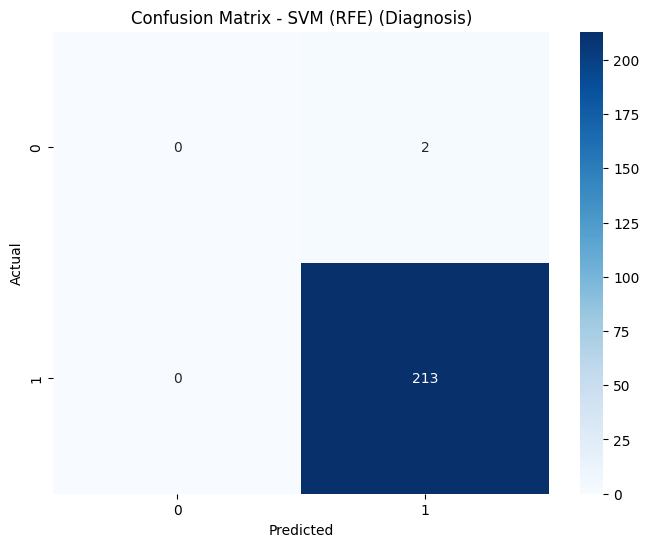

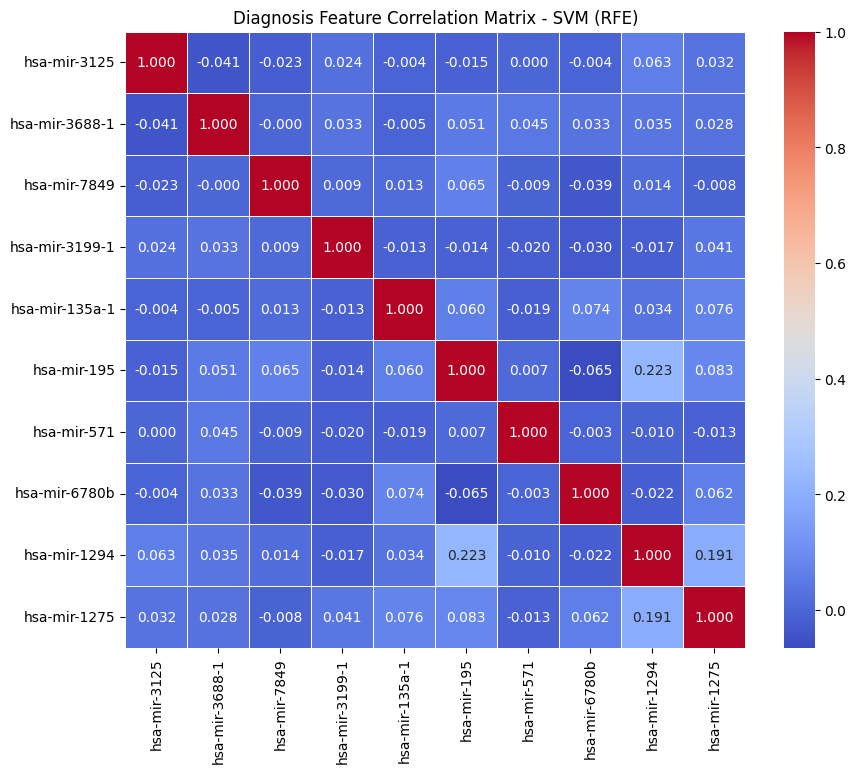

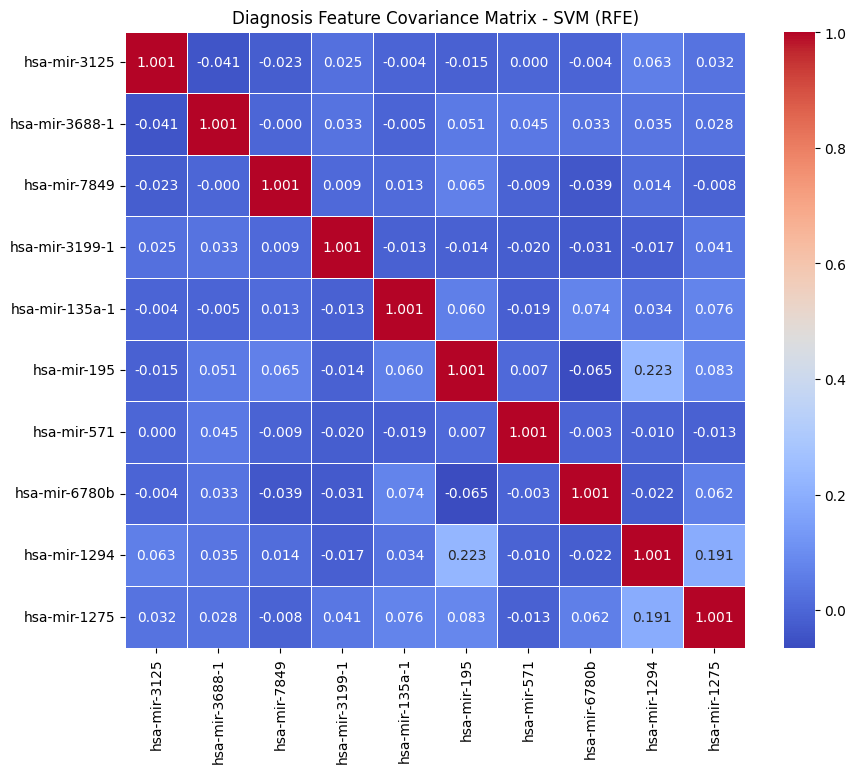

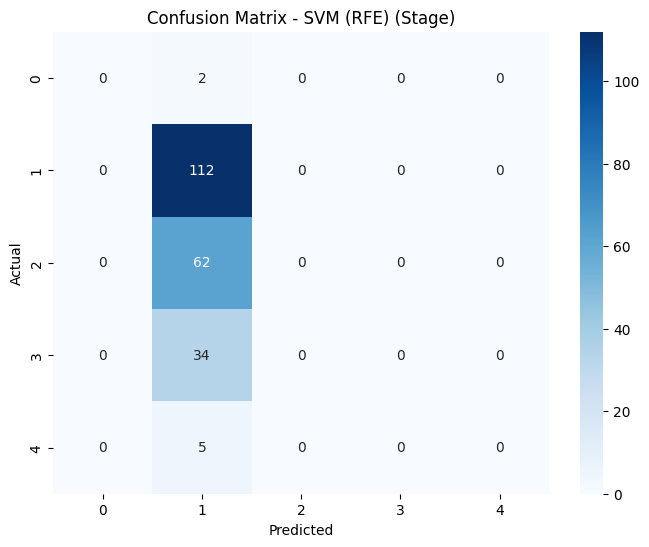

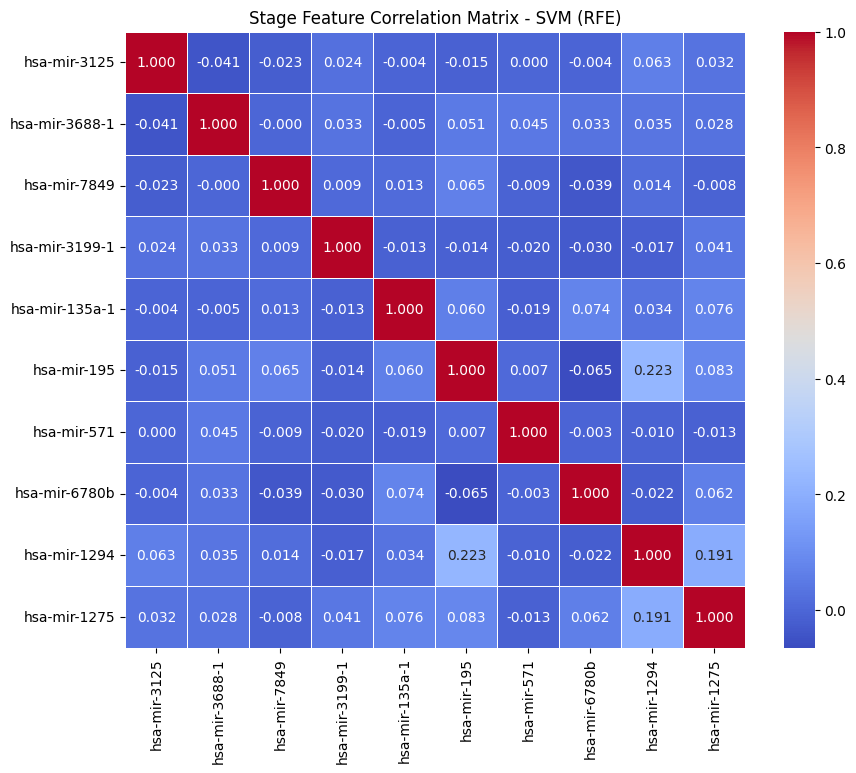

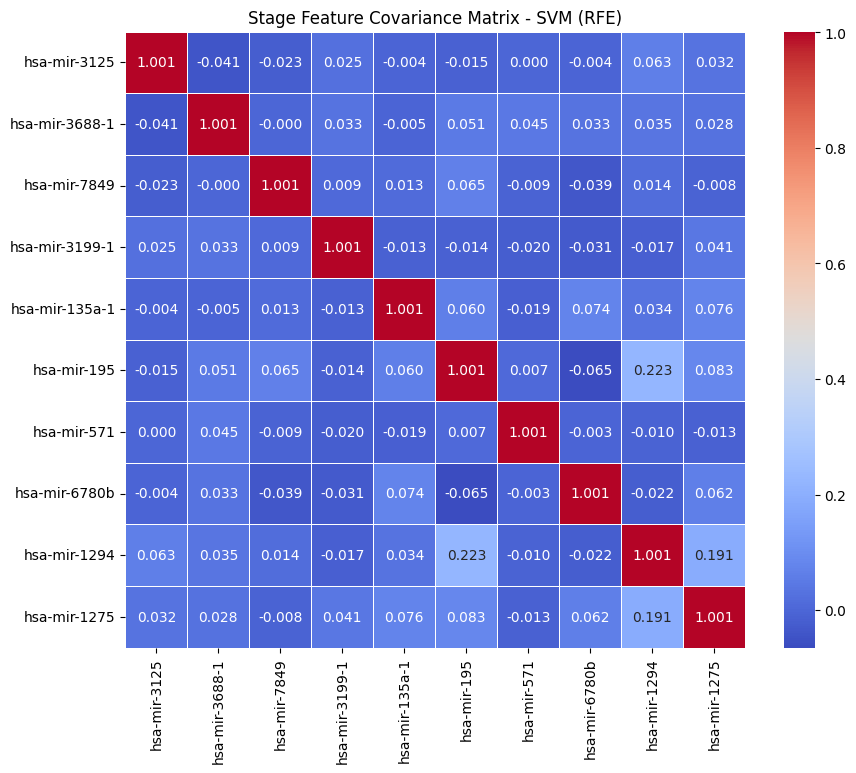

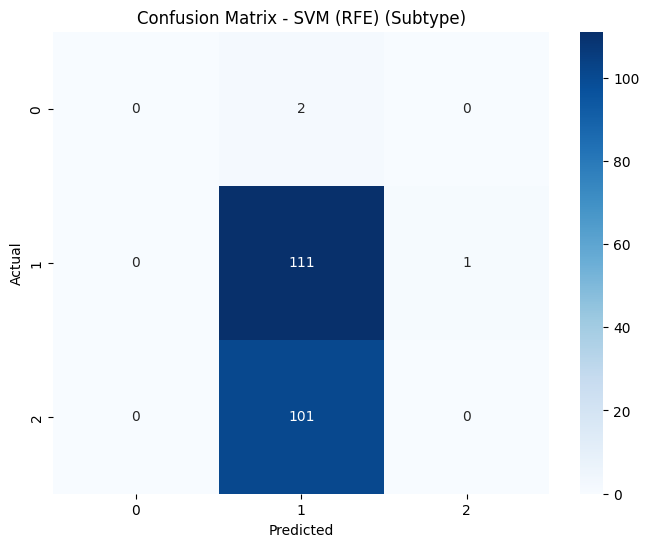

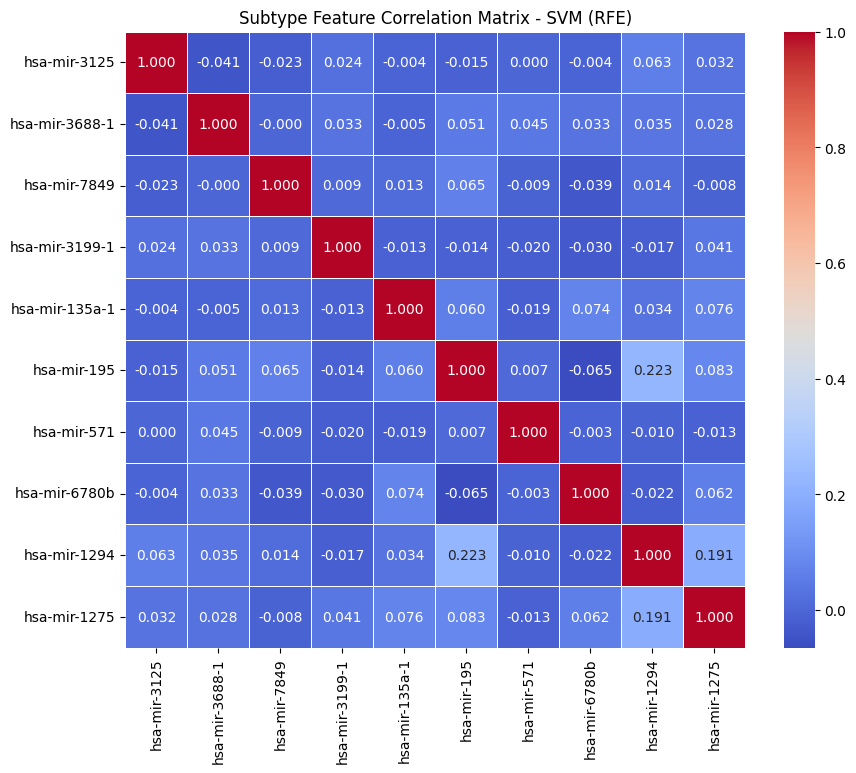

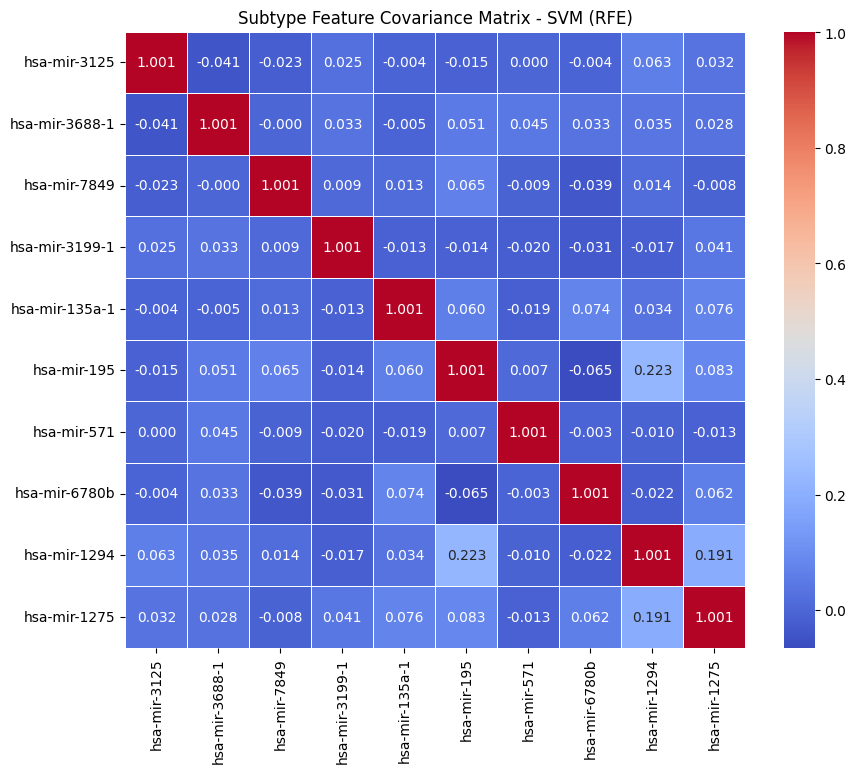

In [11]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import logging

# Logging setup
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

def evaluate_rfe_model(y_test, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (RFE)", save_dir="../results/svm_rfe/"):
    """
    Evaluate multi-output model performance for Diagnosis, Stage, and Subtype,
    including classification reports, confusion matrices, correlation, and covariance analysis.
    """
    os.makedirs(save_dir, exist_ok=True)  # Ensure directory exists

    # Ensure y_test and predictions have the same shape
    min_length = min(len(y_test), len(y_pred_diagnosis), len(y_pred_stage), len(y_pred_subtype))
    y_test_aligned = y_test.iloc[:min_length].reset_index(drop=True)
    y_pred_diagnosis = y_pred_diagnosis[:min_length]
    y_pred_stage = y_pred_stage[:min_length]
    y_pred_subtype = y_pred_subtype[:min_length]

    # Convert predictions to DataFrame
    y_pred_df = pd.DataFrame({
        "diagnosis": y_pred_diagnosis,
        "stage": y_pred_stage,
        "subtype": y_pred_subtype
    })

    # Ensure X_train is a DataFrame
    if not isinstance(X_train, pd.DataFrame):
        X_train = pd.DataFrame(X_train, columns=available_features)

    # Identify and Save Top 10 Features
    top_10_features = X_train.var().sort_values(ascending=False).index[:10].tolist()
    print("\nTop 10 Features Based on Maximum Variance:")
    print(top_10_features)

    top_features_path = os.path.join(save_dir, f"svm_rfe_top_features.txt")
    with open(top_features_path, "w") as f:
        for feature in top_10_features:
            f.write(feature + "\n")
    print(f"\nTop features saved to {top_features_path}")

    print(f"\n{'-'*20} {model_name} Results {'-'*20}")

    # Display and Save Confusion, Correlation, and Covariance Matrices
    for label, cm, name in [
        ("diagnosis", confusion_matrix(y_test_aligned["diagnosis"], y_pred_df["diagnosis"]), "Diagnosis"),
        ("stage", confusion_matrix(y_test_aligned["stage"], y_pred_df["stage"]), "Stage"),
        ("subtype", confusion_matrix(y_test_aligned["subtype"], y_pred_df["subtype"]), "Subtype")
    ]:
        # Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title(f"Confusion Matrix - {model_name} ({name})")
        cm_path = os.path.join(save_dir, f"svm_rfe_{label}_confusion_matrix.png")
        plt.savefig(cm_path)
        plt.show()

        # Correlation & Covariance Matrices (10x10)
        top_variance_features = X_train.var().sort_values(ascending=False).index[:10]
        for matrix, matrix_name in [(X_train[top_variance_features].corr(), "correlation"), (X_train[top_variance_features].cov(), "covariance")]:
            plt.figure(figsize=(10, 8))
            sns.heatmap(matrix, annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5)
            plt.title(f"{name} Feature {matrix_name.capitalize()} Matrix - {model_name}")
            matrix_path = os.path.join(save_dir, f"svm_rfe_{label}_{matrix_name}_matrix.png")
            plt.savefig(matrix_path)
            plt.show()

    return {"top_10_features": top_10_features}

# Run Evaluation
save_dir = "../results/svm_rfe/"
metrics_rfe = evaluate_rfe_model(y_test, y_pred_diagnosis, y_pred_stage, y_pred_subtype, X_train, model_name="SVM (RFE)", save_dir=save_dir)

### Save Everything & Finalize the Pipeline (RFE)

In [12]:
import os
import json
import pandas as pd
import joblib
import logging

# Configure Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# Define Output Directory for RFE Results
output_dir = "../results/svm_rfe/"
os.makedirs(output_dir, exist_ok=True)  # Ensure directory exists

# Ensure `y_test` is properly assigned
if "y_test_stage" not in locals() or "y_test_subtype" not in locals():
    raise ValueError("`y_test_stage` or `y_test_subtype` is missing. Ensure variables are correctly assigned before running this block.")

# Ensure `y_pred_stage` and `y_pred_subtype` exist
if "y_pred_stage" not in locals() or "y_pred_subtype" not in locals():
    raise ValueError("Predictions (`y_pred_stage` or `y_pred_subtype`) are missing. Ensure models have made predictions.")

# Ensure predictions have the same length as `y_test`
min_length = min(len(y_test_stage), len(y_pred_stage), len(y_pred_subtype))
y_test_stage = y_test_stage.iloc[:min_length].reset_index(drop=True)
y_test_subtype = y_test_subtype.iloc[:min_length].reset_index(drop=True)
y_pred_stage = y_pred_stage[:min_length]
y_pred_subtype = y_pred_subtype[:min_length]

# Save Predictions & Actual Labels
y_pred_df = pd.DataFrame({
    "stage": y_pred_stage,
    "subtype": y_pred_subtype
}, index=y_test_stage.index)

predictions_path = os.path.join(output_dir, "svm_rfe_predictions.csv")
y_pred_df.to_csv(predictions_path, index=False)
logging.info(f"Predictions saved to {predictions_path}")
print(f"Predictions saved to {predictions_path}")

actual_labels_path = os.path.join(output_dir, "svm_rfe_actual_labels.csv")
y_test_combined = pd.DataFrame({
    "stage": y_test_stage,
    "subtype": y_test_subtype
})
y_test_combined.to_csv(actual_labels_path, index=False)
logging.info(f"Actual labels saved to {actual_labels_path}")
print(f"Actual labels saved to {actual_labels_path}")

# Save Experiment Metadata
metadata = {
    "stage_hyperparameters": grid_stage.best_params_ if "grid_stage" in locals() else "N/A",
    "subtype_hyperparameters": grid_subtype.best_params_ if "grid_subtype" in locals() else "N/A",
    "stage_accuracy": metrics["stage_accuracy"] if "metrics" in locals() else "N/A",
    "subtype_accuracy": metrics["subtype_accuracy"] if "metrics" in locals() else "N/A",
    "stage_confusion_matrix": metrics["stage_confusion_matrix"] if "metrics" in locals() else "N/A",
    "subtype_confusion_matrix": metrics["subtype_confusion_matrix"] if "metrics" in locals() else "N/A",
    "train_set_size": X_train.shape[0] if "X_train" in locals() else "N/A",
    "test_set_size": X_test.shape[0] if "X_test" in locals() else "N/A"
}

metadata_path = os.path.join(output_dir, "svm_rfe_metadata.json")
with open(metadata_path, "w") as f:
    json.dump(metadata, f, indent=4)
logging.info(f"Metadata saved to {metadata_path}")
print(f"Metadata saved to {metadata_path}")

# Save Separate Models for Stage & Subtype
if "best_svm_stage" in locals():
    model_stage_path = os.path.join(output_dir, "svm_rfe_stage_model.pkl")
    joblib.dump(best_svm_stage, model_stage_path)
    logging.info(f"Stage model saved to {model_stage_path}")
    print(f"Stage model saved to {model_stage_path}")
else:
    logging.warning("`best_svm_stage` is missing. The model was not saved.")

if "best_svm_subtype" in locals():
    model_subtype_path = os.path.join(output_dir, "svm_rfe_subtype_model.pkl")
    joblib.dump(best_svm_subtype, model_subtype_path)
    logging.info(f"Subtype model saved to {model_subtype_path}")
    print(f"Subtype model saved to {model_subtype_path}")
else:
    logging.warning("`best_svm_subtype` is missing. The model was not saved.")

print("\nAll results successfully saved. The SVM pipeline using RFE features is complete.")

2025-02-27 10:11:59,192 - INFO - Predictions saved to ../results/svm_rfe/svm_rfe_predictions.csv
2025-02-27 10:11:59,196 - INFO - Actual labels saved to ../results/svm_rfe/svm_rfe_actual_labels.csv
2025-02-27 10:11:59,199 - INFO - Metadata saved to ../results/svm_rfe/svm_rfe_metadata.json
2025-02-27 10:11:59,206 - INFO - Stage model saved to ../results/svm_rfe/svm_rfe_stage_model.pkl
2025-02-27 10:11:59,212 - INFO - Subtype model saved to ../results/svm_rfe/svm_rfe_subtype_model.pkl


Predictions saved to ../results/svm_rfe/svm_rfe_predictions.csv
Actual labels saved to ../results/svm_rfe/svm_rfe_actual_labels.csv
Metadata saved to ../results/svm_rfe/svm_rfe_metadata.json
Stage model saved to ../results/svm_rfe/svm_rfe_stage_model.pkl
Subtype model saved to ../results/svm_rfe/svm_rfe_subtype_model.pkl

All results successfully saved. The SVM pipeline using RFE features is complete.
